

```
# This is formatted as code
```


# Week 1: NLP Foundations: Preprocessing & Topic Identification

This notebook contains **two activities**:

**Activity 1 (~45 min):** Preprocessing a text corpus step by step  
**Activity 2 (~60 min):** Apply the pipeline to your own text and compare Bag-of-Words vs. TF‑IDF

> You can run this notebook directly in **Google Colab**. It uses **NLTK** and **scikit-learn**.



##  Setup
This installs and imports packages we'll need.


In [ ]:
# Install libraries. You may skip installation if already available.
!pip -q install nltk==3.9.1 scikit-learn==1.5.2 wordcloud==1.9.3

import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('gutenberg', quiet=True)

import re
import math
import collections
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import gutenberg, stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud


---

# Activity 1: Preprocessing a Text Corpus Step by Step

**Goal:** Learn core preprocessing: tokenization, stopwords, stemming vs. lemmatization, Bag‑of‑Words, and TF‑IDF.  
We'll use the **Gutenberg corpus** (*Emma*, Jane Austen).



### 1) Load a Corpus
We will load ***Emma*** (Jane Austen) from the NLTK Gutenberg collection.


In [ ]:

raw_text = gutenberg.raw('austen-emma.txt')
print(raw_text[:800])
print("\nLength (chars):", len(raw_text))


[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died too long ago for her to have more than an indistinct
remembrance of her caresses; and her place had been supplied
by an excellent woman as governess, who had fallen little short
of a mother in affection.

Sixteen years had Miss Taylor been in Mr. Woodhouse's family,
less as a governess than a friend,

Length (chars): 887071



### 2) Tokenization
Split text into **sentences** and **words**. This helps the computer work with language units.


In [ ]:

sentences = sent_tokenize(raw_text)
words = word_tokenize(raw_text)

print("Number of sentences:", len(sentences))
print("Number of word tokens:", len(words))

# Basic cleanup: keep alphabetic words and make lowercase
words_alpha = [w.lower() for w in words if w.isalpha()]
print("Alphabetic tokens:", len(words_alpha))
print("Sample:", words_alpha[:30])


Number of sentences: 7493
Number of word tokens: 191855
Alphabetic tokens: 157114
Sample: ['emma', 'by', 'jane', 'austen', 'volume', 'i', 'chapter', 'i', 'emma', 'woodhouse', 'handsome', 'clever', 'and', 'rich', 'with', 'a', 'comfortable', 'home', 'and', 'happy', 'disposition', 'seemed', 'to', 'unite', 'some', 'of', 'the', 'best', 'blessings', 'of']



### 3) Stopword Removal
**Stopwords** (e.g., *the, is, and*) are common words that often add little meaning for many tasks.


In [ ]:

stop = set(stopwords.words('english'))
words_nostop = [w for w in words_alpha if w not in stop]
print("After stopword removal:", len(words_nostop))
print("Sample:", words_nostop[:30])


After stopword removal: 69693
Sample: ['emma', 'jane', 'austen', 'volume', 'chapter', 'emma', 'woodhouse', 'handsome', 'clever', 'rich', 'comfortable', 'home', 'happy', 'disposition', 'seemed', 'unite', 'best', 'blessings', 'existence', 'lived', 'nearly', 'years', 'world', 'little', 'distress', 'vex', 'youngest', 'two', 'daughters', 'affectionate']



### 4) Stemming vs. Lemmatization
- **Stemming**: heuristic chopping of word endings (can be crude).  
- **Lemmatisation**: uses vocabulary and morphology (more linguistically informed).


In [ ]:

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

sample_words = ["running", "runs", "better", "children", "mice", "studies"]
print("Original  |  Stemmed  |  Lemmatised")
for w in sample_words:
    stem = stemmer.stem(w)
    lemma = lemmatizer.lemmatize(w)  # defaults to noun
    print(f"{w:10s} | {stem:8s} | {lemma:10s}")


Original  |  Stemmed  |  Lemmatised
running    | run      | running   
runs       | run      | run       
better     | better   | better    
children   | children | child     
mice       | mice     | mouse     
studies    | studi    | study     


In [ ]:

# Apply stemming and lemmatization to our corpus tokens
stems = [stemmer.stem(w) for w in words_nostop]
lemmas = [lemmatizer.lemmatize(w) for w in words_nostop]

print("Sample stems:", stems[:20])
print("Sample lemmas:", lemmas[:20])


Sample stems: ['emma', 'jane', 'austen', 'volum', 'chapter', 'emma', 'woodhous', 'handsom', 'clever', 'rich', 'comfort', 'home', 'happi', 'disposit', 'seem', 'unit', 'best', 'bless', 'exist', 'live']
Sample lemmas: ['emma', 'jane', 'austen', 'volume', 'chapter', 'emma', 'woodhouse', 'handsome', 'clever', 'rich', 'comfortable', 'home', 'happy', 'disposition', 'seemed', 'unite', 'best', 'blessing', 'existence', 'lived']



### 5) Bag‑of‑Words (BoW) and TF‑IDF
Convert text to numeric features:
- **BoW** counts how often each word appears.
- **TF‑IDF** downweights common terms and upweights distinctive ones.


In [ ]:

# We'll create small "documents" by grouping sentences for demonstration
docs = []
chunk = []
for i, s in enumerate(sentences[:500]):  # keep it manageable
    chunk.append(s)
    if (i+1) % 10 == 0:  # every 10 sentences becomes one document
        docs.append(" ".join(chunk))
        chunk = []
if chunk:
    docs.append(" ".join(chunk))

print("Number of mini-documents:", len(docs))
print("Sample doc snippet:", docs[0][:300])


Number of mini-documents: 50
Sample doc snippet: [Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her. She was th


In [ ]:

# BoW
bow_vec = CountVectorizer(stop_words='english')
X_bow = bow_vec.fit_transform(docs)

# TF-IDF
tfidf_vec = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vec.fit_transform(docs)

print("BoW shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)


BoW shape: (50, 1679)
TF-IDF shape: (50, 1679)


In [ ]:

# Show top 15 terms by total BoW count
sum_bow = np.asarray(X_bow.sum(axis=0)).ravel()
terms_bow = np.array(bow_vec.get_feature_names_out())
top_idx = sum_bow.argsort()[::-1][:15]
top_terms_bow = list(zip(terms_bow[top_idx], sum_bow[top_idx]))
top_terms_bow


[('mr', np.int64(110)),
 ('miss', np.int64(58)),
 ('emma', np.int64(57)),
 ('good', np.int64(48)),
 ('weston', np.int64(44)),
 ('mrs', np.int64(42)),
 ('harriet', np.int64(34)),
 ('man', np.int64(33)),
 ('thing', np.int64(32)),
 ('think', np.int64(31)),
 ('woodhouse', np.int64(30)),
 ('taylor', np.int64(30)),
 ('knightley', np.int64(29)),
 ('little', np.int64(26)),
 ('great', np.int64(26))]

In [ ]:

# Show top 15 terms by TF-IDF (mean across documents)
mean_tfidf = np.asarray(X_tfidf.mean(axis=0)).ravel()
terms_tfidf = np.array(tfidf_vec.get_feature_names_out())
top_idx_tfidf = mean_tfidf.argsort()[::-1][:15]
top_terms_tfidf = list(zip(terms_tfidf[top_idx_tfidf], mean_tfidf[top_idx_tfidf]))
top_terms_tfidf


[('mr', np.float64(0.07890926672657755)),
 ('miss', np.float64(0.05097035207885753)),
 ('emma', np.float64(0.048582740658415835)),
 ('weston', np.float64(0.04641675937688663)),
 ('harriet', np.float64(0.04261674925586247)),
 ('mrs', np.float64(0.04141035823026187)),
 ('knightley', np.float64(0.04137939189171899)),
 ('good', np.float64(0.04081924664752061)),
 ('taylor', np.float64(0.03638754358816135)),
 ('think', np.float64(0.034692162277253004)),
 ('man', np.float64(0.033772253118701315)),
 ('said', np.float64(0.032415911716743906)),
 ('martin', np.float64(0.03225907589744359)),
 ('woodhouse', np.float64(0.031937342387197115)),
 ('thing', np.float64(0.03162271541747988))]

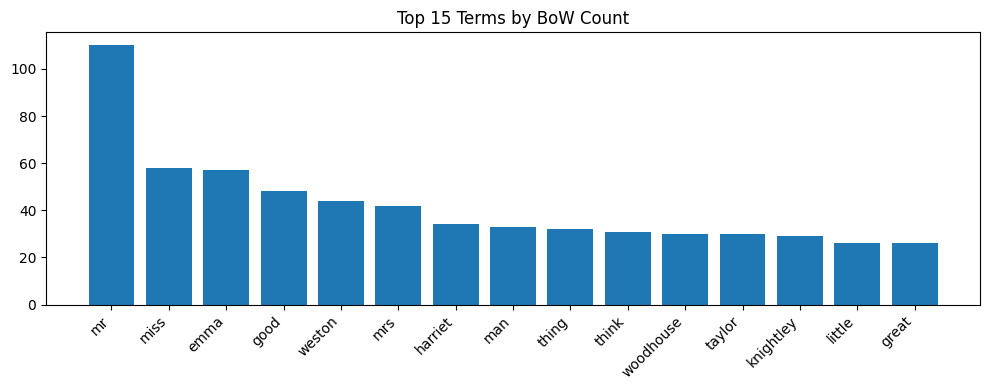

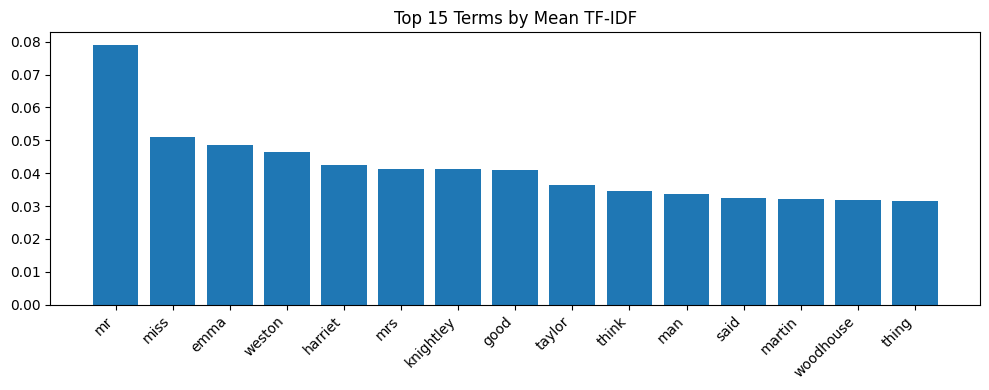

In [ ]:

# Plot BoW vs. TF-IDF top terms (bar charts)
plt.figure(figsize=(10, 4))
labels = [t[0] for t in top_terms_bow]
values = [int(t[1]) for t in top_terms_bow]
plt.bar(labels, values)
plt.title("Top 15 Terms by BoW Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
labels_t = [t[0] for t in top_terms_tfidf]
values_t = [float(t[1]) for t in top_terms_tfidf]
plt.bar(labels_t, values_t)
plt.title("Top 15 Terms by Mean TF-IDF")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



### 6) Word Cloud
A quick visualization of frequent words.


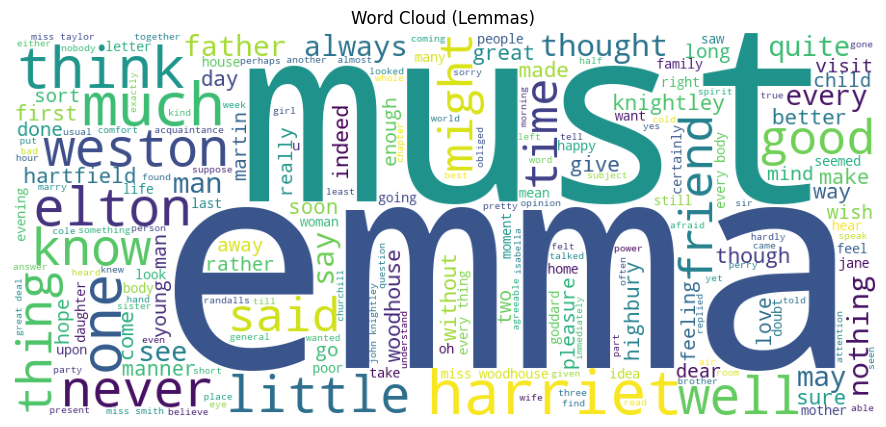

In [ ]:

# Join tokens for a word cloud (from lemmatized version for nicer words)
text_for_wc = " ".join(lemmas[:30000])  # limit size for speed
wc = WordCloud(width=900, height=400, background_color="white").generate(text_for_wc)
plt.figure(figsize=(12, 5))
plt.imshow(wc)
plt.axis("off")
plt.title("Word Cloud (Lemmas)")
plt.show()



---

# Activity 2 : Apply the Pipeline to Your Own Text

**Goal:** Choose your own text, build a preprocessing pipeline, then compare **Bag‑of‑Words** and **TF‑IDF** topic terms.  
Try at least **one extension** (custom stopwords, stemming vs. lemmatisation comparison, or bigrams).



### 1) Choose Your Text
Options:
- Use an NLTK corpus (e.g., Brown, Reuters, movie_reviews), or
- Paste your own text (news article, blog, a Wikipedia section, etc.).


In [ ]:

# OPTION A: Load from an NLTK corpus (uncomment one)
# import nltk; nltk.download('brown', quiet=True); from nltk.corpus import brown; docs_custom = [" ".join(brown.words(categories='news')[:4000])]
# import nltk; nltk.download('reuters', quiet=True); from nltk.corpus import reuters; docs_custom = [" ".join(reuters.words(fileid)[:2000]) for fileid in reuters.fileids()[:8]]
# import nltk; nltk.download('movie_reviews', quiet=True); from nltk.corpus import movie_reviews; docs_custom = [" ".join(movie_reviews.words(fileid)) for fileid in movie_reviews.fileids()[:10]]

# OPTION B: Paste your own text (add multiple docs if you like)

docs_custom = [
    "Get help if your iPhone won't turn on or if the screen is black. You might need to force your iPhone to restart or charge it. Choose your iPhone type. Force your iPhone with Face ID to restart. Press and quickly release the volume up button. Press and quickly release the volume down button. Press and hold the side button until you see the Apple logo (this might take longer than 10 seconds). If your iPhone doesn't turn on, charge your iPhone for one hour and then try again. If your iPhone shows a low-charge battery, check your iPhone hardware and then charge your iPhone for 30 minutes or until it starts. Force your iPhone with a Home button to restart. To force your iPhone to restart, you press a combination of buttons, depending on the kind of iPhone you have.",
    "Restart your iPhone. Learn how to turn your iPhone off, then back on. Press and hold either volume button and the side button until the power-off slider appears.Drag the slider, then wait 30 seconds for your device to turn off. If your device is frozen or unresponsive, force restart your device. To turn your device back on, press and hold the side button (on the right side of your iPhone) until you see the Apple logo. Press and hold the side button until the power-off slider appears. Drag the slider, then wait 30 seconds for your device to turn off. If your device is frozen or unresponsive, force restart your device. To turn your device back on, press and hold the side button until you see the Apple logo. Press and hold the top button until the power-off slider appears.",
    "Learn what to do if you don't see your device listed, you see an alert that says your device is offline, or you see an unexpected device in Find My. I don't see my device in Find My. I see my device in Find My, but it's offline. I see a device that I don’t own or use anymore. I use a device associated with a business or educational institution. I don't see my device in Find My. Make sure that you set up Find My on your device. You have to set up Find My before you can see your device in the Find My app or on iCloud.com/find. If your device is missing, learn how to mark your device as lost and protect your information. Check that you signed in to iCloud on your device using your Apple Account: Tap Settings. If you see \"Sign in to your [device],\" tap it and enter your Apple Account email address or phone number and password."
]

len(docs_custom), [d[:120] for d in docs_custom]


(3,
 ["Get help if your iPhone won't turn on or if the screen is black. You might need to force your iPhone to restart or charg",
  'Restart your iPhone. Learn how to turn your iPhone off, then back on. Press and hold either volume button and the side b',
  "Learn what to do if you don't see your device listed, you see an alert that says your device is offline, or you see an u"])


### 2) Build Your Preprocessing Pipeline
Tokenize → remove stopwords → lemmatize (or stem). Feel free to **customize stopwords**.


In [ ]:
# TODO: Write your own preprocessing here
# Steps:
# 1. Tokenize text
# 2. Lowercase words
# 3. Remove stopwords
# 4. Lemmatize words

def my_preprocess(text):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens if w.isalpha()]
    stop = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

docs_clean = [my_preprocess(doc) for doc in docs_custom]


### 3) Compare Bag‑of‑Words vs. TF‑IDF
Compute top terms for each representation and **compare**.


In [ ]:

# BoW
bow_vec2 = CountVectorizer(max_features=2000, ngram_range=(1,3))  # try (1,2) for bigrams
X_bow2 = bow_vec2.fit_transform(docs_clean)
terms_bow2 = np.array(bow_vec2.get_feature_names_out())
sum_bow2 = np.asarray(X_bow2.sum(axis=0)).ravel()
top_idx2 = sum_bow2.argsort()[::-1][:20]
list(zip(terms_bow2[top_idx2], sum_bow2[top_idx2]))


[('device', np.int64(22)),
 ('iphone', np.int64(15)),
 ('see', np.int64(12)),
 ('button', np.int64(11)),
 ('press', np.int64(9)),
 ('restart', np.int64(7)),
 ('turn', np.int64(7)),
 ('find', np.int64(7)),
 ('force', np.int64(6)),
 ('hold', np.int64(6)),
 ('side', np.int64(6)),
 ('press hold', np.int64(6)),
 ('see device', np.int64(6)),
 ('device find', np.int64(5)),
 ('apple', np.int64(5)),
 ('slider', np.int64(5)),
 ('side button', np.int64(5)),
 ('force iphone', np.int64(4)),
 ('device turn', np.int64(4)),
 ('hold side button', np.int64(4))]

In [ ]:

# TF-IDF
tfidf_vec2 = TfidfVectorizer(max_features=2000, ngram_range=(1,1))
X_tfidf2 = tfidf_vec2.fit_transform(docs_clean)
terms_tfidf2 = np.array(tfidf_vec2.get_feature_names_out())
mean_tfidf2 = np.asarray(X_tfidf2.mean(axis=0)).ravel()
top_idx_tfidf2 = mean_tfidf2.argsort()[::-1][:15]
list(zip(terms_tfidf2[top_idx_tfidf2], mean_tfidf2[top_idx_tfidf2]))


[('device', np.float64(0.37447285279131326)),
 ('iphone', np.float64(0.28258213803055926)),
 ('button', np.float64(0.2048776611753808)),
 ('press', np.float64(0.16757097541031085)),
 ('see', np.float64(0.15690340363425795)),
 ('find', np.float64(0.14971155570326372)),
 ('restart', np.float64(0.13088251071024865)),
 ('turn', np.float64(0.1296460685802332)),
 ('slider', np.float64(0.12060230528741323)),
 ('force', np.float64(0.11253827836021754)),
 ('hold', np.float64(0.11068361516519439)),
 ('side', np.float64(0.11068361516519439)),
 ('charge', np.float64(0.0748000423933243)),
 ('back', np.float64(0.07236138317244792)),
 ('apple', np.float64(0.06848134711005655))]


### 4) (Optional) Try an Extension
- Add **custom stopwords** and see how top terms change.  
- Switch to **bigrams**: set `ngram_range=(1,2)` in the vectorizers.  
- Compare **stemming vs. lemmatization** outputs.


In [ ]:

# Example: switch to bigrams for BoW and TF-IDF
bow_vec_bigram = CountVectorizer(max_features=2000, ngram_range=(1,2))
tfidf_vec_bigram = TfidfVectorizer(max_features=2000, ngram_range=(1,2))

X_bow_bigram = bow_vec_bigram.fit_transform(docs_clean)
X_tfidf_bigram = tfidf_vec_bigram.fit_transform(docs_clean)

terms_bow_bigram = bow_vec_bigram.get_feature_names_out()[:20]
terms_tfidf_bigram = tfidf_vec_bigram.get_feature_names_out()[:20]

terms_bow_bigram[:20], terms_tfidf_bigram[:20]
